# Assignment 3: Image Classification

In this assignment, we will build a convolutional neural network that can predict
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network mostly by yourself.

When you are finished with the assignment make sure you submit the following files:
1. this file (ML_DL_Assignment3.ipynb) compressed to zip.
2. the functions file (ML_DL_Functions3.py).
3. the model parameters for the first model from section 3.3 ('best_CNN_model.pk').
4. the model parameters for the second model from section 3.3 ('best_CNNChannel_model.pk').

## Grading Method
In this assignment you are given alot more freedom to implement your own models and training proccedures. Yet we still need an automatic method for testing your codes. This means that there are a few things which have to be done correctly in order for the testing to pass:
1. Your preprocessing has to be exactly the same as the preprocessing done on the test set. To ensure this happens you got a small sample of validation images to compare your preprocessing to the test.
2. your models have to be written in pytorch, they have to accept the correct input shape and output the correct shape and type.
3. your models will be instantiated on the testing server without any arguments so make sure to not include any in your models.
4. The values in the output of the model should have the correct meaning. For that reason you were given a prewritten get_accuracy function. make sure it works with your model without changing the function.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import sys
from PIL import Image, ImageOps
from torch.utils.data import random_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def reload_functions():
  if 'ML_DL_Functions3' in sys.modules:
    del sys.modules['ML_DL_Functions3']
  functions_path = drive_path.replace(" ","\ ") + 'ML_DL_Functions3.py'
  !cp $functions_path .

## 1. Data

Download the data from the course website. make sure you have both the template python functions file and the dataset data directory on the same directory in your google drive.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/MyDrive/Fourth_Year/Semester1/Intro_Deep_learning/HW3/' # TODO - UPDATE ME!


Mounted at /content/gdrive


After you have done so, read this entire section
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### 1.1 Loading and Preprocessing the data

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair.
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `Image.open`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed.
**The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1.** Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [3]:
# # Your code goes here. Make sure it does not get cut off
# # You can use the code below to help you get started. You're welcome to modify
# # the code or remove it entirely: it's just here so that you don't get stuck
# # reading files

# import glob

# images_train = np.zeros((200, 3, 2, 224, 224, 3), dtype=np.float64)
# images_test_m = np.zeros((200, 3, 2, 224, 224, 3), dtype=np.float64)
# images_test_w = np.zeros((200, 3, 2, 224, 224, 3), dtype=np.float64)

# for data_kind in ['train', 'test_m', 'test_w']:
#   path = drive_path + f"data/{data_kind}/*.jpg"
#   i=0
#   for file in glob.glob(path):
#     filename = file.split("/")[-1]            # get the name of the .jpg file
#     img = np.asarray(Image.open(file))   # read the image as a numpy array
#     img = img[:,:,:3] / 255 - 0.5 # remove the alpha channel
#     filename_vals = filename.split("_")
#     left_right = 0 if filename_vals[2] == 'left' else 1

#     if data_kind == 'train':
#       images_train[int(filename_vals[0][1:])-1, int(filename_vals[1])-1, left_right] = img
#     elif data_kind == 'test_m':
#       images_test_m[int(filename_vals[0][1:])-1, int(filename_vals[1])-1, left_right] = img
#     elif data_kind == 'test_w':
#       images_test_w[int(filename_vals[0][1:])-1, int(filename_vals[1])-1, left_right] = img

# train_data = images_train
# train_data =  train_data[np.nonzero(np.any(train_data != 0, axis=(3, 4, 5)))]
# train_data = train_data.reshape((112, 3, 2, 224,224, 3))

# idx_80 = int(0.95*len(train_data))
# valid_data = train_data[idx_80:,:,:,:,:,:]
# train_data = train_data[:idx_80]

# test_m_data = images_test_m
# test_m_data =  test_m_data[np.nonzero(np.any(test_m_data != 0, axis=(3, 4, 5)))]
# test_m_data = test_m_data.reshape((10, 3, 2, 224,224, 3))

# test_w_data = images_test_w
# test_w_data =  test_w_data[np.nonzero(np.any(test_w_data != 0, axis=(3, 4, 5)))]
# test_w_data = test_w_data.reshape((10, 3, 2, 224,224, 3))

In [ ]:
# np.save(drive_path + 'data/valid_data.npy', valid_data)
# np.save(drive_path + 'data/train_data.npy', train_data)
# np.save(drive_path + 'data/test_w_data.npy', test_w_data)
# np.save(drive_path + 'data/test_m_data.npy', test_m_data)

In [4]:
valid_data = np.load(drive_path + 'data/valid_data.npy')
train_data = np.load(drive_path + 'data/train_data.npy')
test_w_data = np.load(drive_path + 'data/test_w_data.npy')
test_m_data = np.load(drive_path + 'data/test_m_data.npy')

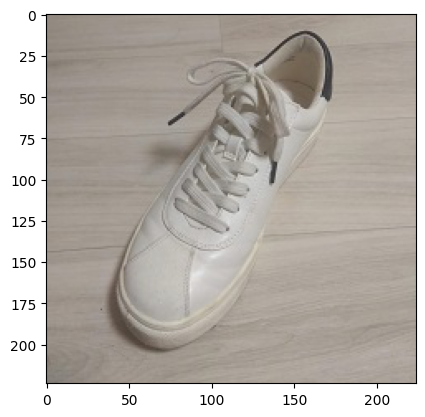

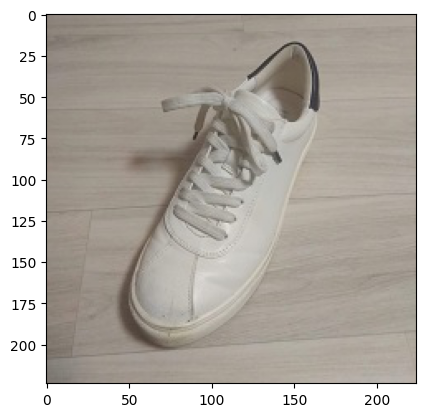

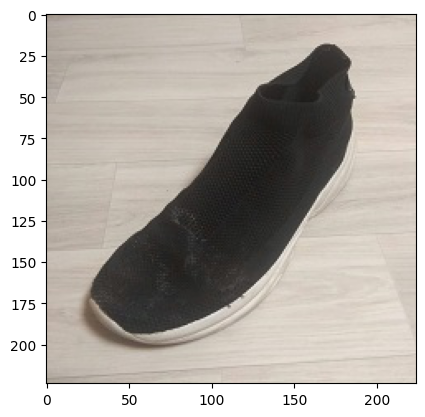

In [5]:
# Run this code
test1 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test1.npy")
test2 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test2.npy")
test3 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test3.npy")
if (test1 != train_data[4,0,0,:,:,:]).any() or \
   (test2 != train_data[4,0,1,:,:,:]).any() or \
   (test3 != train_data[4,1,1,:,:,:]).any():
   print("preprocessing error, make sure you followed all instructions carefully")

plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### 1.2 Generating Same Pairs

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(106, 3, 2, 224, 224, 3)
(318, 448, 224, 3)
Number of blank pictures in generated data: 0


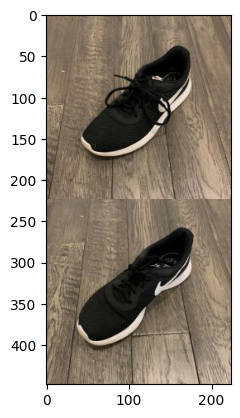

In [6]:
# Your code goes here
def generate_same_pair(data):
  shape_im = data.shape
  new_data = np.zeros((shape_im[0]*shape_im[1], 448, 224, 3), dtype=np.float64)
  i = 0
  for person in range(shape_im[0]):
    for pair in range(shape_im[1]):
      img_left = data[person, pair,0,:,:,:]
      img_right = data[person, pair,1,:,:,:]
      new_data[i, :224,:,:] = img_left
      new_data[i, 224:,:,:] = img_right
      i += 1
  return new_data

# Run this code
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

## Sanity Check
# Generate same pair data
new_data = generate_same_pair(train_data)

# Count blank pictures
blank_count = np.sum(np.all(new_data == 0, axis=(1, 2, 3)))
print("Number of blank pictures in generated data:", blank_count)

### 1.3 Generate Different Pairs

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(106, 3, 2, 224, 224, 3)
(318, 448, 224, 3)


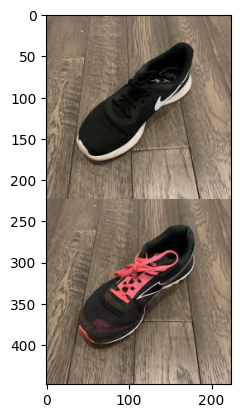

In [7]:
# Your code goes here
def generate_different_pair(data):
  shape_im = data.shape
  new_data = np.zeros((shape_im[0]*shape_im[1], 448, 224, 3), dtype=np.float64)
  i = 0
  # set a random vector for choice
  for person in range(shape_im[0]):
    vector = np.array([1, 2, 3, 4, 5, 6])
    while any(abs(np.diff(vector)) == 1):
        np.random.shuffle(vector)

    options = {1: data[person, 0,0,:,:,:], 2: data[person, 0,1,:,:,:], 3: data[person, 1,0,:,:,:],
             4: data[person, 1,1,:,:,:], 5: data[person, 2,0,:,:,:], 6: data[person, 2,1,:,:,:]}

    # choose to create different pairs randommaly
    new_data[i, :224,:,:] = options[vector[0]]
    new_data[i, 224:,:,:] = options[vector[1]]
    new_data[i+1, :224,:,:]  = options[vector[2]]
    new_data[i+1, 224:,:,:]  = options[vector[3]]
    new_data[i+2, :224,:,:]  = options[vector[4]]
    new_data[i+2, 224:,:,:]  = options[vector[5]]
    i += 3
  return new_data

# Run this code
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[2]+0.5) # should show 2 shoes from different pairs


#### Food for thought

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)
The floors are different in each triplet. this will make it easier for the model to learn the shoes features and not the floor features.

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and
1% of the images are shoes that *are* from the same pair. Why could this be a problem?
this will cause bias in the learning - it will more likely predict that the shoes are from different pair

## 2. Convolutional Neural Networks

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.



### 2.1 Convolutional Model

Open the functions file(ML_DL_Functions3.py) and Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

make sure the CNN's constructor(__init__) function has no arguments. Instantiate the variable $n$ inside the constructor(__init__) of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.
make sure the output of the model has a shape of (N,2) where N is the batch_size.

### 2.2 Channeled Convolutional Neural Network

Open the functions file(ML_DL_Functions3.py) and Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

make sure the output of the model has a shape of (N,2) where N is the batch_size.

#### Food for thought

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. why would one of these models perform better?

One treats the whole image a one so the NN will think it's one picture and won't analyze the saptial correlation. and the other seperates it into different channels, which treats it like two different pics.



### 2.3 Get Accuracy

The function `get_accuracy` is written for you.

Unlike in the previous assignment, here we will separately compute the model accuracy on the
positive and negative samples.

In [8]:
def get_accuracy(model, data, batch_size=50,device='cpu'):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]
    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]
    pos_correct = 0

    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

In [10]:
reload_functions()
import ML_DL_Functions3

model = ML_DL_Functions3.CNN() # create untrained model
pos_acc, neg_acc= get_accuracy(model, valid_data)
false_positive = 1 - pos_acc
false_negative = 1 - neg_acc

#### Food for thought
why do we wish to track the false positives and false negatives separately?
FP are the ones who are not the same pair but were identified as the same. this will make a person wear two different shoes.
FN are the ones who are not the same pair but predicted as the same pair. Each on of these measures should be considered - as it might be more important to keep FP as low as possible or otherwise.

## 3. Training

Now, we will write the functions required to train the model.

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target. We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### 3.1 train model

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image.
- computing the forward and backward passes
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch.

In [11]:
def loss_valid(model, criterion):
  model.eval()
  pos = torch.from_numpy(generate_same_pair(valid_data)).to(torch.float32)
  neg = torch.from_numpy(generate_different_pair(valid_data)).to(torch.float32)
  pairs_tensor = torch.cat((pos, neg), axis=0).permute(0,3,1,2).to(torch.float32).to(device)
  labels = torch.cat((torch.ones(len(pos)), torch.zeros(len(neg))), axis=0).to(torch.long).to(device)
  pred = model(pairs_tensor) # Predict output
  loss = criterion(pred, labels) # Compute the loss
  return loss

In [12]:
from torch.utils.data import DataLoader

# you can change the signature and structure of this function as you please
# the code and comments below are only a suggestion to get you started
def train_model(model,
                train_data=train_data,
                validation_data=valid_data,
                batch_size=30,
                learning_rate=0.01,
                weight_decay=0,
                epochs=15,
                checkpoint_path=None, model_name=None):

  model = model.to(device)
  loss_min = 0.5

  # Initialize Loss function and optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # Create the positive and negative pairs

  train_acc, valid_acc, loss_all, loss_val_all = [], [], [], []
  train_pos = generate_same_pair(train_data)
  train_loader_pos = DataLoader(train_pos, batch_size//2, shuffle=True, drop_last=True)
  train_neg = generate_different_pair(train_data)
  train_loader_neg = DataLoader(train_neg, batch_size//2, shuffle=True, drop_last=True)

  for epoch in range(epochs):
    model.train()
    # # shuffle the positive and negative pairs
    for i, pos in enumerate(train_loader_pos):
      neg = next(iter(train_loader_neg))

      # Create the labels of the batch and combine the positive and negative half batches
      # Conversion from numpy array to torch tensor (if working with gpu also change device to gpu)
      train_pairs_tensor = torch.cat((pos, neg), axis=0).permute(0,3,1,2).to(torch.float32).to(device)
      labels = torch.cat((torch.ones(batch_size//2), torch.zeros(batch_size//2)), axis=0).to(torch.long).to(device)

      optimizer.zero_grad() # Reset the optimizer
      pred = model(train_pairs_tensor) # Predict output
      loss = criterion(pred, labels) # Compute the loss
      loss.backward() # Backward pass
      optimizer.step() # Update the parameters

  # track the accuracy and loss of the training and validation
    model.eval()
    train_acc.append(get_accuracy(model, train_data, device=device))
    valid_acc.append(get_accuracy(model, validation_data, device=device))
    loss_all.append(loss.item())
    loss_val = loss_valid(model, criterion)
    loss_val_all.append(loss_val.item())
    print(f"Epoch {epoch+1}; Loss train {np.round(loss.item(),4)}; Loss valid: {np.round(loss_val.item(),4)}; Train Acc {np.round(train_acc[-1],2)}; Val Acc {np.round(valid_acc[-1],2)}")

  # checkpoint the model
    if checkpoint_path is not None:
        # Save checkpoint
        torch.save(model.state_dict(), checkpoint_path+f"{epoch}.pk")
        if loss.item() < loss_min:
          loss_min = loss.item()
          torch.save(model.state_dict(), checkpoint_path+f"BEST{model_name}_Nadav.pk")

  if np.abs(loss_all[epoch] - loss_all[epoch-1]) < 1e-6:
    return model, train_acc, valid_acc, loss_all

  plt.plot(loss_all)
  plt.plot(loss_val_all)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  return model, train_acc, valid_acc, loss_all


### 3.2 Sanity check

Sanity check your code from 3.1 and from 2.1 and 2.2 by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ training accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [ ]:
reload_functions()
import ML_DL_Functions3
model = ML_DL_Functions3.CNNChannel()
model, train_acc, valid_acc, loss = train_model(model, train_data[0:2], batch_size=6, epochs=50, learning_rate=0.001, weight_decay=0)

In [ ]:
reload_functions()
import ML_DL_Functions3
model = ML_DL_Functions3.CNN() # create untrained model
model, train_acc, valid_acc, loss = train_model(model, train_data[0:2], batch_size=6, epochs=50, learning_rate=0.001)

### 3.3 training and saving the optimal model

Train your models from Q2(a) and Q2(b). Change the values of a few
hyperparameters, including the learning rate, batch size, choice of $n$, and
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, choose your hyperparameters run the training and save the model in the drive. You should try to save the your **single best** model.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using.  Remember to submit the model with your code in the moodle submission.

It is recommended to plot the training curves.

Epoch 1; Loss train 0.7469; Loss valid: 0.6937; Train Acc [1. 0.]; Val Acc [1. 0.]
Epoch 2; Loss train 0.7627; Loss valid: 0.6981; Train Acc [1. 0.]; Val Acc [1. 0.]
Epoch 3; Loss train 0.6873; Loss valid: 0.6971; Train Acc [1.   0.01]; Val Acc [1. 0.]
Epoch 4; Loss train 0.6521; Loss valid: 0.666; Train Acc [0.97 0.16]; Val Acc [0.94 0.22]
Epoch 5; Loss train 0.6265; Loss valid: 0.6642; Train Acc [0.68 0.57]; Val Acc [0.72 0.61]
Epoch 6; Loss train 0.6349; Loss valid: 0.6474; Train Acc [0.45 0.78]; Val Acc [0.56 0.89]
Epoch 7; Loss train 0.5682; Loss valid: 0.5676; Train Acc [0.58 0.74]; Val Acc [0.67 0.78]
Epoch 8; Loss train 0.5308; Loss valid: 0.5932; Train Acc [0.79 0.58]; Val Acc [0.83 0.56]
Epoch 9; Loss train 0.5693; Loss valid: 0.5117; Train Acc [0.9 0.6]; Val Acc [1.   0.56]
Epoch 10; Loss train 0.4967; Loss valid: 0.4361; Train Acc [0.86 0.65]; Val Acc [0.94 0.83]
Epoch 11; Loss train 0.4378; Loss valid: 0.5655; Train Acc [0.79 0.72]; Val Acc [0.89 0.72]
Epoch 12; Loss train

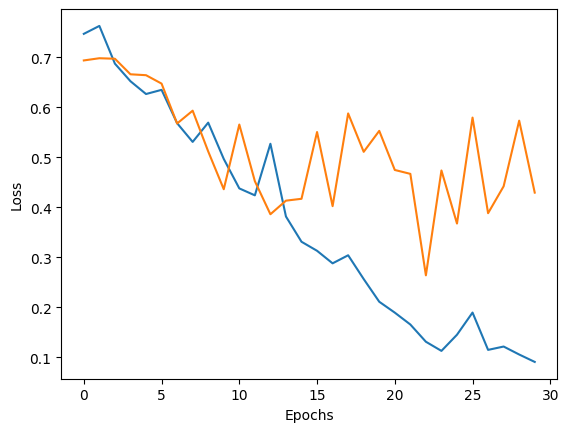

Epoch 1; Loss train 0.7065; Loss valid: 0.6939; Train Acc [0.96 0.03]; Val Acc [0.94 0.  ]
Epoch 2; Loss train 0.6945; Loss valid: 0.6932; Train Acc [1. 0.]; Val Acc [1. 0.]
Epoch 3; Loss train 0.6908; Loss valid: 0.6934; Train Acc [0. 1.]; Val Acc [0. 1.]
Epoch 4; Loss train 0.6952; Loss valid: 0.6901; Train Acc [0.09 0.96]; Val Acc [0.17 0.94]
Epoch 5; Loss train 0.6862; Loss valid: 0.6913; Train Acc [0.4  0.74]; Val Acc [0.61 0.56]
Epoch 6; Loss train 0.6933; Loss valid: 0.6849; Train Acc [0.29 0.81]; Val Acc [0.33 0.72]
Epoch 7; Loss train 0.6644; Loss valid: 0.6737; Train Acc [0.39 0.79]; Val Acc [0.17 0.83]
Epoch 8; Loss train 0.655; Loss valid: 0.6344; Train Acc [0.48 0.78]; Val Acc [0.22 0.94]
Epoch 9; Loss train 0.544; Loss valid: 0.7107; Train Acc [0.07 0.98]; Val Acc [0.11 1.  ]
Epoch 10; Loss train 0.5008; Loss valid: 1.2108; Train Acc [0.07 1.  ]; Val Acc [0.06 1.  ]
Epoch 11; Loss train 0.4584; Loss valid: 0.833; Train Acc [0.26 0.98]; Val Acc [0.17 1.  ]
Epoch 12; Loss t

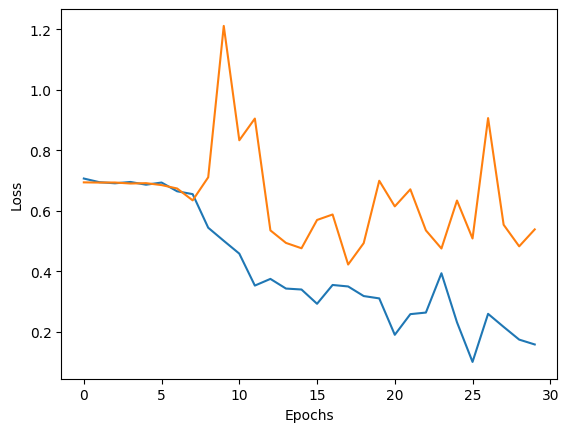

In [17]:
reload_functions()
import ML_DL_Functions3
CNN_model = ML_DL_Functions3.CNN() # this has to be the blueprint for the model(don't add arguments)
CNNChannel_model = ML_DL_Functions3.CNNChannel() # this has to be the blueprint for the model(don't add arguments)

# Insert your training here
CNN_model, train_acc_CNN, valid_acc_CNN, loss_CNN = train_model(CNN_model, batch_size=64, epochs=30, learning_rate=0.001, checkpoint_path=drive_path+"checkpoints_CNN/", model_name='CNN')
CNNChannel_model, train_acc_CNNChannel, valid_acc_CNNChannel, loss_CNNChannel = train_model(CNNChannel_model, batch_size=64, epochs=30, learning_rate=0.001, weight_decay=0.001, checkpoint_path=drive_path+"checkpoints_Nadav/", model_name='CNNChannel')

In [ ]:
# Save the best model
import pickle
CNNChannel_model = ML_DL_Functions3.CNNChannel()
path_CNN_Channel = drive_path+"checkpoints_Nadav/15.pk"
CNNChannel_model.load_state_dict(torch.load(path_CNN_Channel))

CNN_model = ML_DL_Functions3.CNN()
path_CNN = drive_path+"checkpoints_CNN/26.pk"
CNN_model.load_state_dict(torch.load(path_CNN))

In [ ]:
# Run the following code and submit to the moodle the two models saved
checkpoint_path  = drive_path+"checkpoints/" # you can change the path
torch.save(CNN_model.state_dict(), checkpoint_path+"best_CNN_model.pk") # Do not change the name of the checkpoint file
torch.save(CNNChannel_model.state_dict(), checkpoint_path+"best_CNNChannel_model.pk") # Do not change the name of the checkpoint file

8


<All keys matched successfully>

In [18]:
# Load the best models
checkpoint_path  = drive_path+"checkpoints/" # you can change the path
CNN_model = ML_DL_Functions3.CNN()
CNN_model.load_state_dict(torch.load(checkpoint_path+"best_CNN_model.pk"))
CNNChannel_model = ML_DL_Functions3.CNNChannel()
CNNChannel_model.load_state_dict(torch.load(checkpoint_path+"best_CNNChannel_model.pk"))


<All keys matched successfully>

In [33]:
# Making sure
print((get_accuracy(CNNChannel_model.to(device), valid_data, device=device)))
print((get_accuracy(CNN_model.to(device), valid_data, device=device)))

(0.8888888888888888, 0.7777777777777778)
(0.9444444444444444, 0.7222222222222222)


## 4. Testing


This part is mainly to help you get a feeling of your models performance. It should not take you long to finish.

### 4.1. Accuracies

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [34]:
# CNN
reload_functions()
import ML_DL_Functions3
m_acc, w_acc = [], []
for i in range(30):
  m_acc.append(get_accuracy(CNN_model.to(device), test_m_data, device=device))
  w_acc.append(get_accuracy(CNN_model.to(device), test_w_data, device=device))


print(f'Mens CNN mean accuarcy:{np.round(np.mean(m_acc,axis=0),3)}, {np.round(np.mean(m_acc),2)}')
print(f'Womens CNN mean accuarcy:{np.round(np.mean(w_acc,axis=0),3)}, {np.round(np.mean(w_acc),2)}')

Mens CNN mean accuarcy:[0.933 0.662], 0.8
Womens CNN mean accuarcy:[0.867 0.774], 0.82


In [35]:
# CNN Channel
reload_functions()
import ML_DL_Functions3
m_acc, w_acc = [], []
for i in range(30):
  m_acc.append(get_accuracy(CNNChannel_model.to(device), test_m_data, device=device))
  w_acc.append(get_accuracy(CNNChannel_model.to(device), test_w_data, device=device))


print(f'Mens CNNChannel mean accuarcy:{np.round(np.mean(m_acc,axis=0),3)}, {np.round(np.mean(m_acc),2)}')
print(f'Womens CNNChannel mean accuarcy:{np.round(np.mean(w_acc,axis=0),3)}, {np.round(np.mean(w_acc),2)}')

Mens CNNChannel mean accuarcy:[0.867 0.768], 0.82
Womens CNNChannel mean accuarcy:[0.9   0.852], 0.88


Notice that this testing has a random element to it, depending on which images where chosen in the generate pairs. In order to grade your code the testing will be run multiple times to reduce the randomness.

### 4.2 Men's Shoes example

Display one set of men's shoes that your model correctly classified as being
from the same pair.

display one set of inputs that your model classified incorrectly.


CNNChannel_model classified correctly - TP


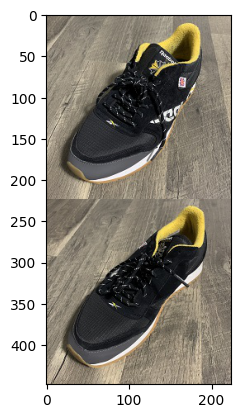

CNNChannel_model classified incorrectly - FP


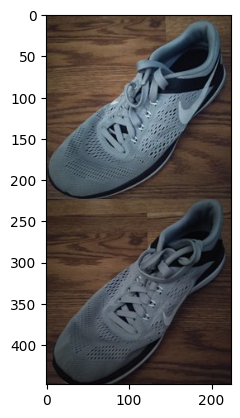

In [53]:
# CNN_Channel
model = CNNChannel_model
data_pos = generate_same_pair(test_m_data)
data_neg = generate_different_pair(test_m_data)

xs = torch.Tensor(data_pos).permute(0,3,1,2)
xs = xs.to(device)
zs = model(xs)
pred = zs.max(1, keepdim=True)[1]
pred = pred.detach().cpu().numpy()

print('CNNChannel_model classified correctly - TP')
for i in range(len(data_pos)):
  if pred[i]:
    plt.imshow(data_pos[i]+0.5)
    plt.show()
    break

print('CNNChannel_model classified incorrectly - FP')
for i in range(len(data_pos)):
  if pred[i]==0:
    plt.imshow(data_pos[i]+0.5)
    plt.show()
    break

CNN_model classified correctly - TP


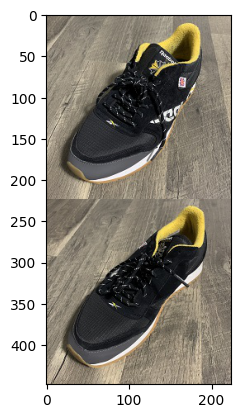

CNN_model classified incorrectly - FP


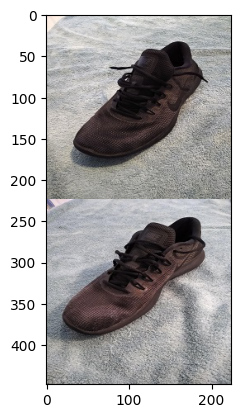

In [52]:
# CNN
model = CNN_model
data_pos = generate_same_pair(test_m_data)
data_neg = generate_different_pair(test_m_data)

xs = torch.Tensor(data_pos).permute(0,3,1,2)
xs = xs.to(device)
zs = model(xs)
pred = zs.max(1, keepdim=True)[1]
pred = pred.detach().cpu().numpy()

print('CNN_model classified correctly - TP')
for i in range(len(data_pos)):
  if pred[i]:
    plt.imshow(data_pos[i]+0.5)
    plt.show()
    break

print('CNN_model classified incorrectly - FP')
for i in range(len(data_pos)):
  if pred[i]==0:
    plt.imshow(data_pos[i]+0.5)
    plt.show()
    break


### 4.2 Women's Shoes example

Display one set of women's shoes that your model correctly classified as being
from the same pair.

display one set of inputs that your model classified incorrectly.

In [ ]:
# CNN_Channel
model = CNNChannel_model
data_pos = generate_same_pair(test_w_data)
data_neg = generate_different_pair(test_w_data)

xs = torch.Tensor(data_pos).permute(0,3,1,2)
xs = xs.to(device)
zs = model(xs)
pred = zs.max(1, keepdim=True)[1]
pred = pred.detach().cpu().numpy()

print('CNNChannel_model classified correctly - TP')
for i in range(len(data_pos)):
  if pred[i]:
    plt.imshow(data_pos[i]+0.5)
    plt.show()
    break

print('CNNChannel_model classified incorrectly - FP')
for i in range(len(data_pos)):
  if pred[i]==0:
    plt.imshow(data_pos[i]+0.5)
    plt.show()
    break

CNN_model classified correctly - TP


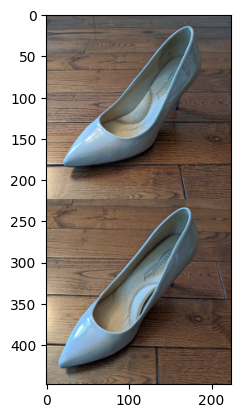

CNN_model classified incorrectly - FP


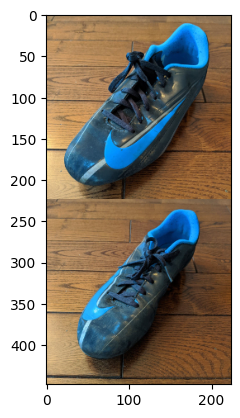

In [51]:
# CNN
model = CNN_model
data_pos = generate_same_pair(test_w_data)
data_neg = generate_different_pair(test_w_data)

xs = torch.Tensor(data_pos).permute(0,3,1,2)
xs = xs.to(device)
zs = model(xs)
pred = zs.max(1, keepdim=True)[1]
pred = pred.detach().cpu().numpy()

print('CNN_model classified correctly - TP')
for i in range(len(data_pos)):
  if pred[i]:
    plt.imshow(data_pos[i]+0.5)
    plt.show()
    break

print('CNN_model classified incorrectly - FP')
for i in range(len(data_pos)):
  if pred[i]==0:
    plt.imshow(data_pos[i]+0.5)
    plt.show()
    break